In [3]:
import sys
import os
import pickle

library_path = os.path.join('..', '..', 'UCB-USACE-LSTMs')
sys.path.insert(0, library_path)

from pathlib import Path
import pandas as pd

import matplotlib.pyplot as plt
import torch
from neuralhydrology.evaluation.metrics import *
from neuralhydrology.nh_run import start_run, eval_run, finetune
from neuralhydrology.utils.nh_results_ensemble import create_results_ensemble
from neuralhydrology.UCB_training.UCB_train import UCB_trainer
from neuralhydrology.evaluation.metrics import calculate_all_metrics

Quick check that working directory and train basin file exists:

In [4]:
print("Current Working Directory:", os.getcwd())
print("Train Basin File Exists:", os.path.exists("calpella"))

Current Working Directory: /Users/mia/research/UCB-USACE-LSTMs/neuralhydrology/calpella_all
Train Basin File Exists: True


Run regular LSTM:

In [5]:
path_to_csv = Path("/Users/mia/research/russian_river_data_folder/")
path_to_yaml = Path("calpella_gage.yaml")
params = {
    "epochs":32
}
lstmNoPhysics = UCB_trainer(path_to_csv, yaml_path= path_to_yaml, hyperparams= params)

In [6]:
lstmNoPhysics.train()

2024-11-30 14:03:11,727: Logging to /Users/mia/research/UCB-USACE-LSTMs/neuralhydrology/calpella_all/runs/testing_run_3011_140311/output.log initialized.
2024-11-30 14:03:11,728: ### Folder structure created at /Users/mia/research/UCB-USACE-LSTMs/neuralhydrology/calpella_all/runs/testing_run_3011_140311
2024-11-30 14:03:11,730: ### Run configurations for testing_run
2024-11-30 14:03:11,733: experiment_name: testing_run
2024-11-30 14:03:11,734: train_basin_file: calpella
2024-11-30 14:03:11,736: validation_basin_file: calpella
2024-11-30 14:03:11,739: test_basin_file: calpella
2024-11-30 14:03:11,741: train_start_date: 1994-10-01 00:00:00
2024-11-30 14:03:11,743: train_end_date: 2002-09-30 00:00:00
2024-11-30 14:03:11,744: validation_start_date: 2002-10-01 00:00:00
2024-11-30 14:03:11,746: validation_end_date: 2005-09-30 00:00:00
2024-11-30 14:03:11,748: test_start_date: 2005-10-01 00:00:00
2024-11-30 14:03:11,750: test_end_date: 2009-09-30 00:00:00
2024-11-30 14:03:11,752: device: cpu


Using basin: Calpella
Using target variable: NR CALPELLA FLOW COE CPL


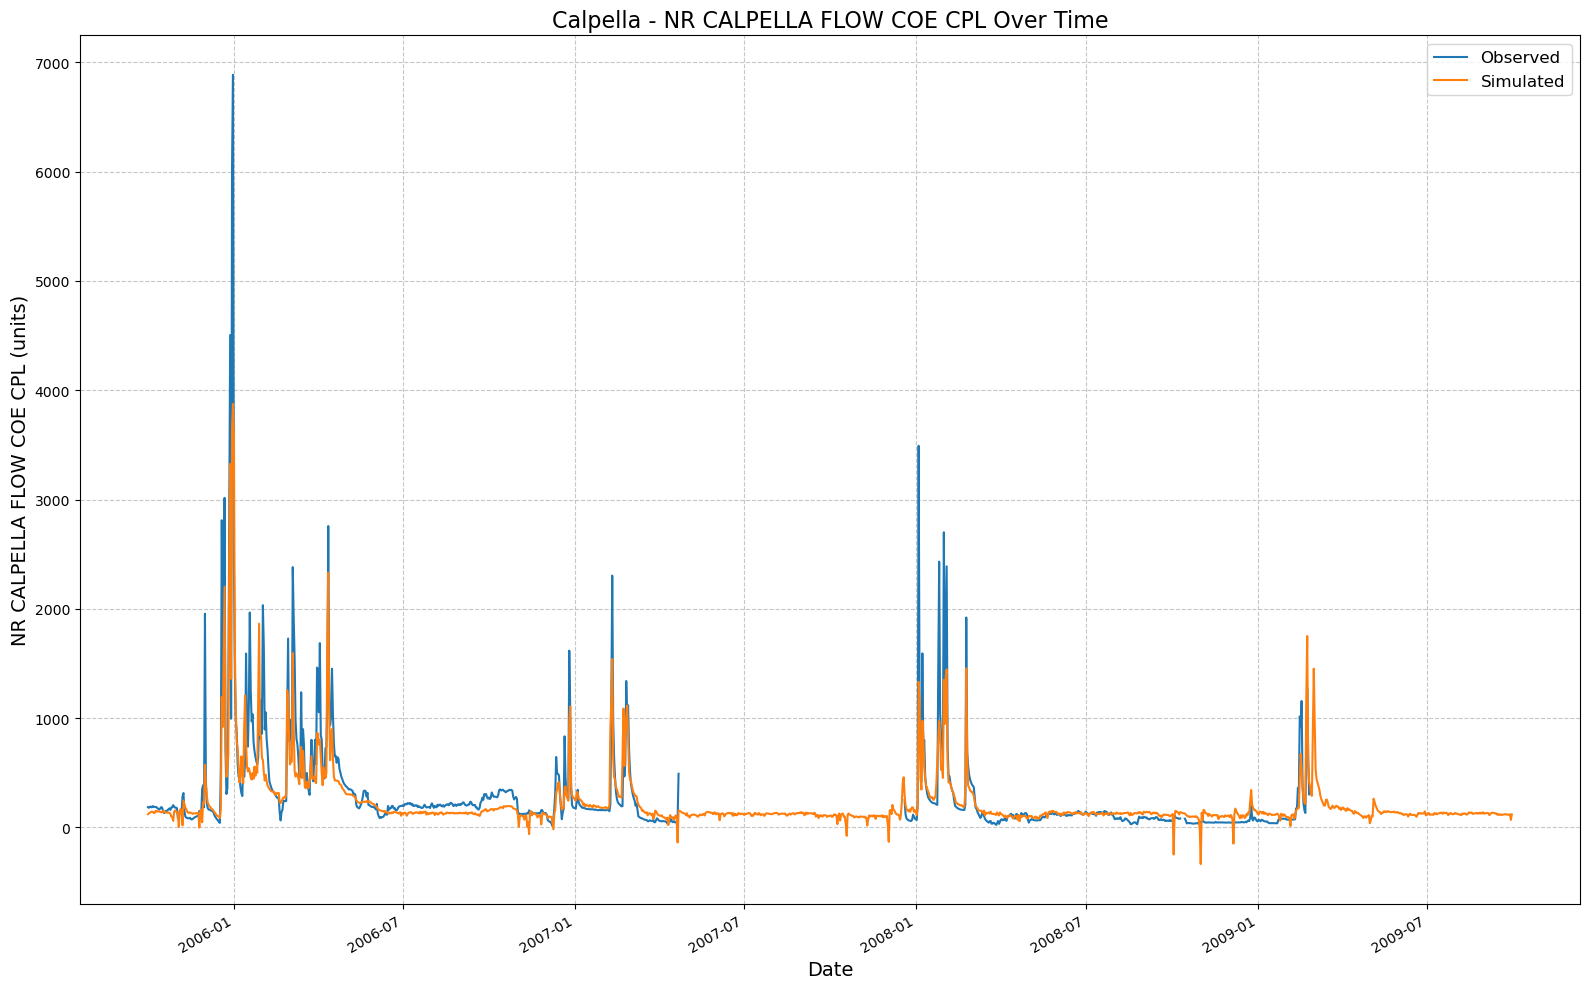

[INFO] CSV output saved at: /Users/mia/research/UCB-USACE-LSTMs/neuralhydrology/calpella_all/runs/testing_run_3011_140311/results_output.csv


{'NSE': 0.7593425214290619,
 'MSE': 61290.58984375,
 'RMSE': 247.56936370187245,
 'KGE': 0.6472379740580847,
 'Alpha-NSE': 0.688420180182926,
 'Beta-KGE': 0.8681886792182922,
 'Beta-NSE': -0.07743278425561567,
 'Pearson-r': 0.9000758360395946,
 'FHV': -29.394453763961792,
 'FMS': -29.740107111196583,
 'FLV': -988.3996896452018,
 'Peak-Timing': 0.25,
 'Peak-MAPE': 39.902849197387695}

In [7]:
lstmNoPhysics.results()

compare evaluation results not using UCB_train():

In [8]:
# change directory to directory specified by the second line of the output of cell 2 above this one

run_dir = Path("/Users/mia/research/UCB-USACE-LSTMs/neuralhydrology/calpella_all/runs/testing_run_3011_133451")
eval_run(run_dir=run_dir, period="test")

with open(run_dir / "test" / "model_epoch032" / "test_results.p", "rb") as fp:
    results = pickle.load(fp)
    
results['Calpella']['1D']['xr']

2024-11-30 14:06:44,612: Using the model weights from /Users/mia/research/UCB-USACE-LSTMs/neuralhydrology/calpella_all/runs/testing_run_3011_133451/model_epoch032.pt
# Evaluation: 100%|██████████| 1/1 [00:00<00:00,  1.30it/s]
2024-11-30 14:06:45,420: Stored metrics at /Users/mia/research/UCB-USACE-LSTMs/neuralhydrology/calpella_all/runs/testing_run_3011_133451/test/model_epoch032/test_metrics.csv
2024-11-30 14:06:45,425: Stored results at /Users/mia/research/UCB-USACE-LSTMs/neuralhydrology/calpella_all/runs/testing_run_3011_133451/test/model_epoch032/test_results.p


<xarray.Dataset>
Dimensions:                       (date: 1461, time_step: 1)
Coordinates:
  * date                          (date) datetime64[ns] 2005-10-01 ... 2009-0...
  * time_step                     (time_step) int64 0
Data variables:
    NR CALPELLA FLOW COE CPL_obs  (date, time_step) float32 184.2 178.0 ... nan
    NR CALPELLA FLOW COE CPL_sim  (date, time_step) float32 134.9 ... 129.3

Text(0.5, 1.0, 'Calpella Gage Validation period - NSE 0.774')

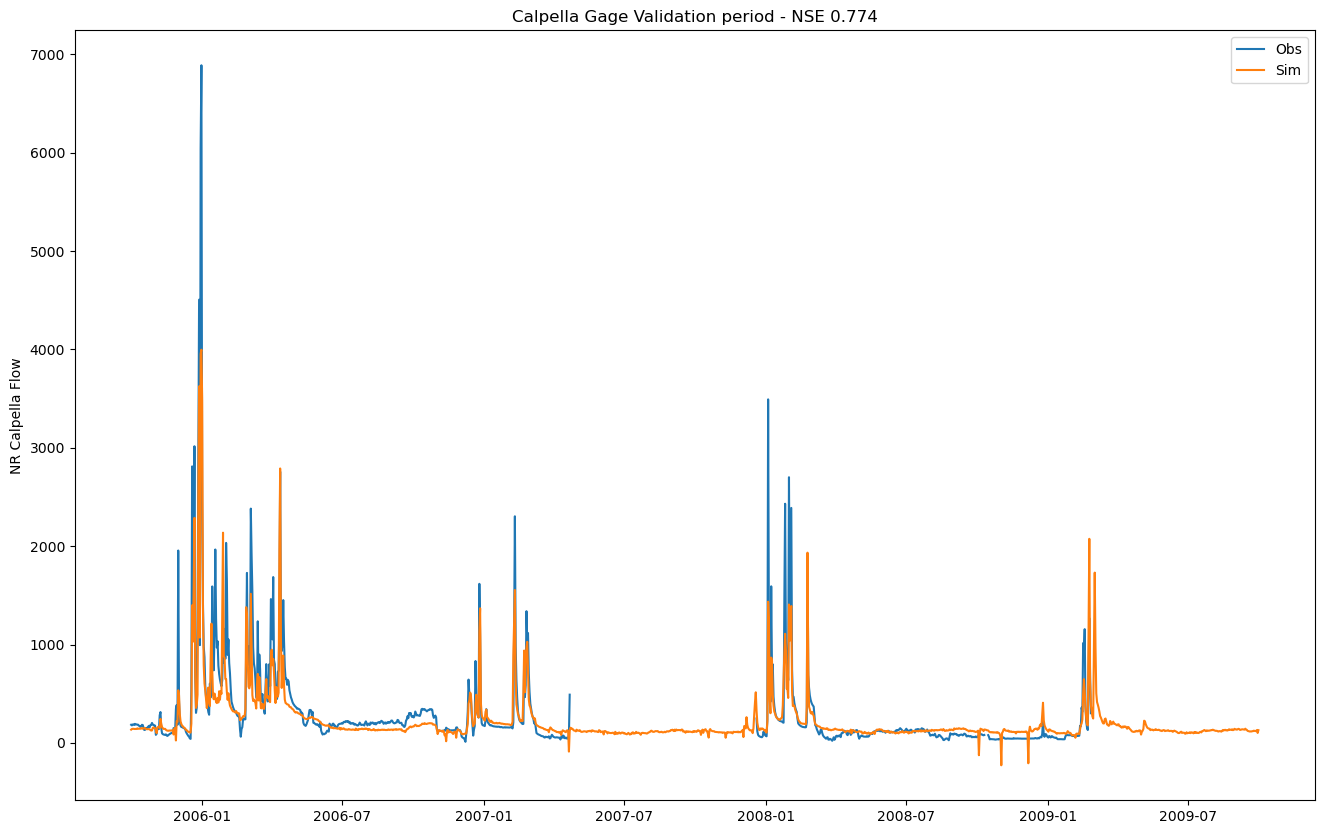

In [9]:

# extract observations and LSTM simulations
qobs = results['Calpella']['1D']['xr']['NR CALPELLA FLOW COE CPL_obs']
qsim = results['Calpella']['1D']['xr']['NR CALPELLA FLOW COE CPL_sim']

fig, ax = plt.subplots(figsize=(16,10))
ax.plot(qobs["date"], qobs, label="Obs")
ax.plot(qsim["date"], qsim, label="Sim")
ax.set_ylabel("NR Calpella Flow")
ax.legend()
ax.set_title(f"Calpella Gage Validation period - NSE {results['Calpella']['1D']['NSE']:.3f}")

this looks the same which means UCB_train is working as it should :)

Now run physics informes lstm with HMS data:

In [8]:
path_to_csv = Path("/Users/mia/research/russian_river_data_folder/")
path_to_yaml = Path("calpella_gage.yaml")
path_to_physics_data = Path("/Users/mia/research/russian_river_data_folder/calpella.csv")
params = {
    "epochs":32
}
features_with_physics = [
    #from daily
    "EF RUSSIAN 20 ET-POTENTIAL RUN:BASIN AVERAGE 60 YR",
    "EF RUSSIAN 20 PRECIP-INC SCREENED",
    "POTTER VALLEY CA FLOW USGS_ADJUSTED",
    "UKIAH CA HUMIDITY USAF-NOAA",
    "UKIAH CA SOLAR RADIATION USAF-NOAA",
    "UKIAH CA TEMPERATURE USAF-NOAA",
    "UKIAH CA WINDSPEED USAF-NOAA",
    #from capella.csv
    'Capella Gage FLOW Calpella',
    'EF Russian 20 ET-POTENTIAL Calpella',
    'EF Russian 20 FLOW Calpella',
    'EF Russian 20 FLOW-BASE Calpella',
    'EF Russian 20 INFILTRATION Calpella',
    'EF Russian 20 PERC-SOIL Calpella',
    'EF Russian 20 SATURATION FRACTION Calpella'
]
lstmPhysics = UCB_trainer(path_to_csv, yaml_path= path_to_yaml, hyperparams= params, input_features= features_with_physics, physics_informed=True, physics_data_file=path_to_physics_data)

In [9]:
lstmPhysics.train()

2024-11-30 13:42:16,538: Logging to /Users/mia/research/UCB-USACE-LSTMs/neuralhydrology/calpella_all/runs/testing_run_3011_134216/output.log initialized.
2024-11-30 13:42:16,553: ### Folder structure created at /Users/mia/research/UCB-USACE-LSTMs/neuralhydrology/calpella_all/runs/testing_run_3011_134216
2024-11-30 13:42:16,555: ### Run configurations for testing_run
2024-11-30 13:42:16,566: experiment_name: testing_run
2024-11-30 13:42:16,570: train_basin_file: calpella
2024-11-30 13:42:16,584: validation_basin_file: calpella
2024-11-30 13:42:16,604: test_basin_file: calpella
2024-11-30 13:42:16,608: train_start_date: 1994-10-01 00:00:00
2024-11-30 13:42:16,610: train_end_date: 2002-09-30 00:00:00
2024-11-30 13:42:16,613: validation_start_date: 2002-10-01 00:00:00
2024-11-30 13:42:16,614: validation_end_date: 2005-09-30 00:00:00
2024-11-30 13:42:16,615: test_start_date: 2005-10-01 00:00:00
2024-11-30 13:42:16,616: test_end_date: 2009-09-30 00:00:00
2024-11-30 13:42:16,620: device: cpu


Using basin: Calpella
Using target variable: NR CALPELLA FLOW COE CPL


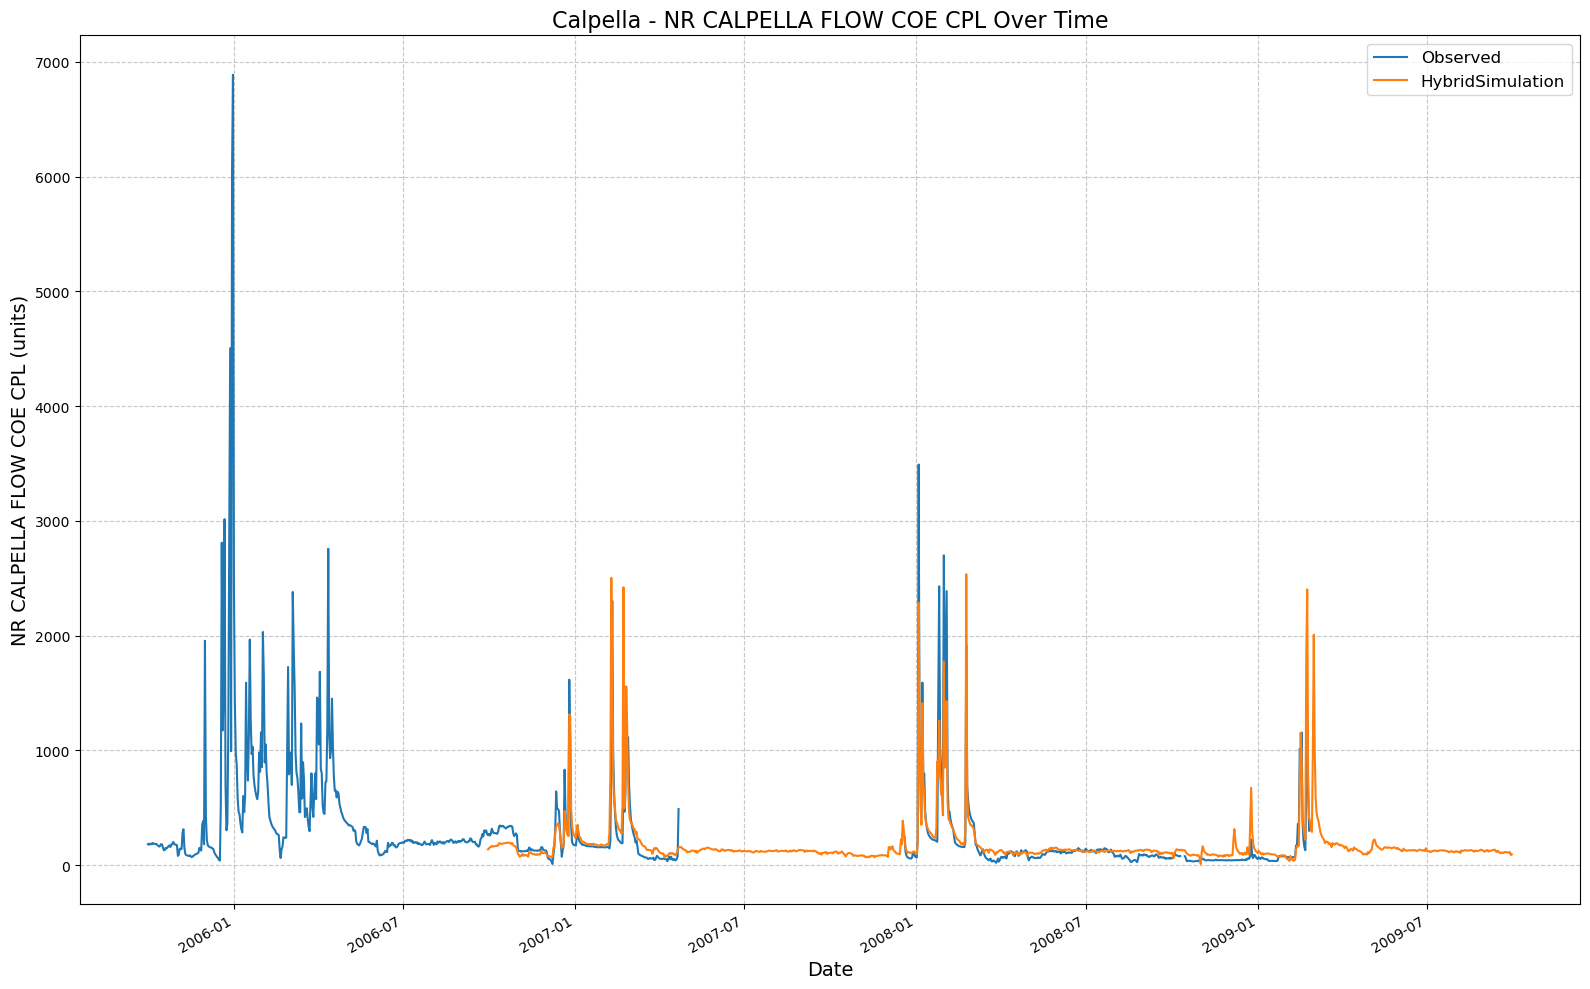

[INFO] CSV output saved at: /Users/mia/research/UCB-USACE-LSTMs/neuralhydrology/calpella_all/runs/testing_run_3011_134216/results_output.csv


{'NSE': 0.7244240045547485,
 'MSE': 28870.3203125,
 'RMSE': 169.91268437788864,
 'KGE': 0.8082719727082127,
 'Alpha-NSE': 0.910375977563823,
 'Beta-KGE': 1.0870945453643799,
 'Beta-NSE': 0.05294078823618706,
 'Pearson-r': 0.8545981044850791,
 'FHV': -3.790094330906868,
 'FMS': -41.091196096097896,
 'FLV': -45.45933612777306,
 'Peak-Timing': 0.0,
 'Peak-MAPE': 47.541026274363205}

In [13]:
lstmPhysics.results()

Comparison to results from physicsLSTM : The following cells test the physics informed for the validation period, the way evan did in the testing_notebook

In [10]:
run_dir = Path('/Users/mia/research/UCB-USACE-LSTMs/neuralhydrology/calpella_all/runs/testing_run_3011_134216')
eval_run(run_dir=run_dir, period="test")

2024-11-30 13:47:18,388: Using the model weights from /Users/mia/research/UCB-USACE-LSTMs/neuralhydrology/calpella_all/runs/testing_run_3011_134216/model_epoch032.pt
# Evaluation: 100%|██████████| 1/1 [00:01<00:00,  1.01s/it]
2024-11-30 13:47:19,417: Stored metrics at /Users/mia/research/UCB-USACE-LSTMs/neuralhydrology/calpella_all/runs/testing_run_3011_134216/test/model_epoch032/test_metrics.csv
2024-11-30 13:47:19,430: Stored results at /Users/mia/research/UCB-USACE-LSTMs/neuralhydrology/calpella_all/runs/testing_run_3011_134216/test/model_epoch032/test_results.p


In [11]:
with open(run_dir / "test" / "model_epoch032" / "test_results.p", "rb") as fp:
    results = pickle.load(fp)
    
results['Calpella']['1D']['xr']

<xarray.Dataset>
Dimensions:                       (date: 1461, time_step: 1)
Coordinates:
  * date                          (date) datetime64[ns] 2005-10-01 ... 2009-0...
  * time_step                     (time_step) int64 0
Data variables:
    NR CALPELLA FLOW COE CPL_obs  (date, time_step) float32 184.2 178.0 ... nan
    NR CALPELLA FLOW COE CPL_sim  (date, time_step) float32 nan nan ... 94.18

Text(0.5, 1.0, 'Calpella Gage Validation period - NSE 0.724')

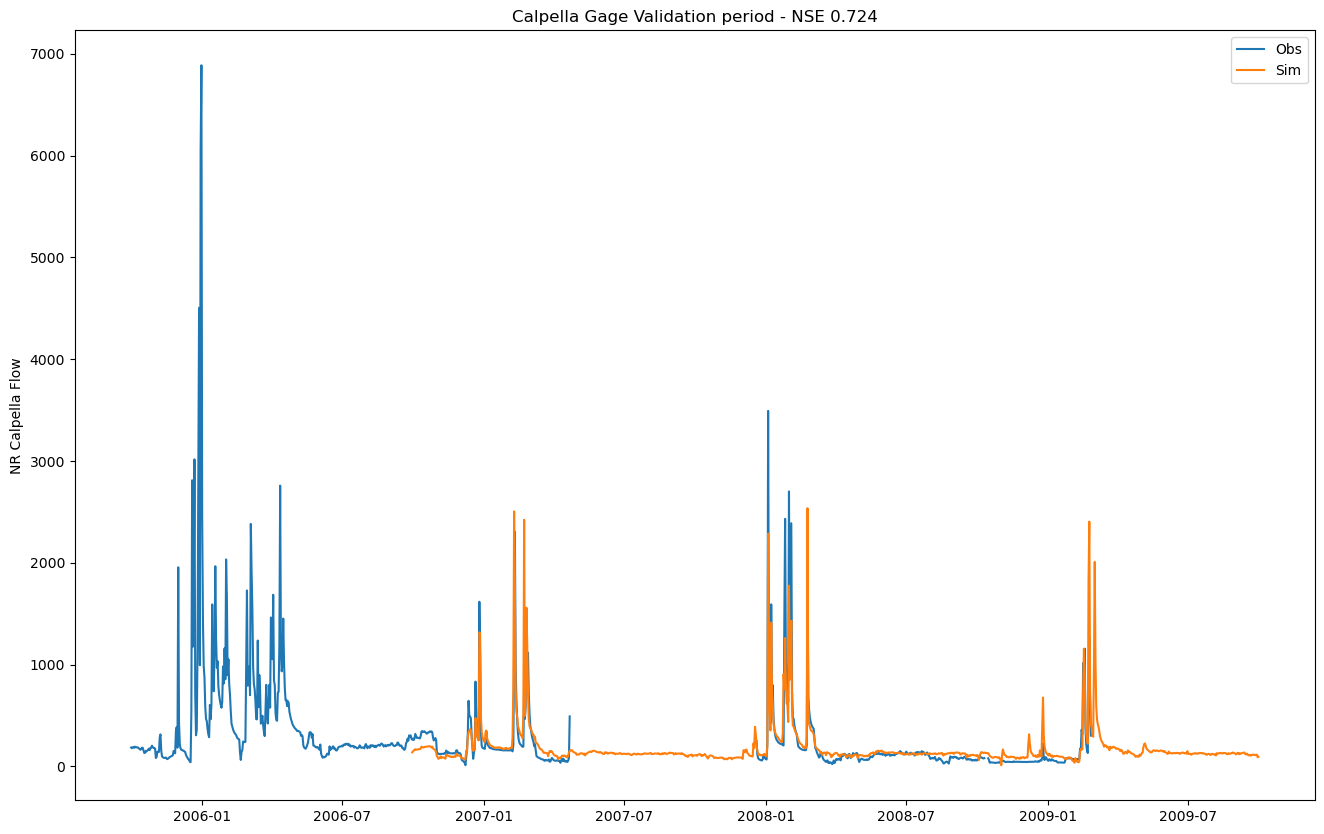

In [12]:

# extract observations and LSTM simulations
qobs = results['Calpella']['1D']['xr']['NR CALPELLA FLOW COE CPL_obs']
qsim = results['Calpella']['1D']['xr']['NR CALPELLA FLOW COE CPL_sim']

fig, ax = plt.subplots(figsize=(16,10))
ax.plot(qobs["date"], qobs, label="Obs")
ax.plot(qsim["date"], qsim, label="Sim")
ax.set_ylabel("NR Calpella Flow")
ax.legend()
ax.set_title(f"Calpella Gage Validation period - NSE {results['Calpella']['1D']['NSE']:.3f}")

The following function combines the the results for the normal lstm, physics informed lstm and the hms results on one graph over a specified time period.

In [15]:
def combinedPlot(lstm_results: Path, lstmPhysics_results: Path, HMS_results: Path, title: str, 
                 test_start_date="01/10/2005", test_end_date="30/09/2009"):
    model1_df = pd.read_csv(lstm_results) #colums: Date, Observed, Predicted
    model2_df = pd.read_csv(lstmPhysics_results) #colums: Date, Observed, Predicted
    model1_df = model1_df.rename(columns={
        'Date': 'date',
        'Observed': 'Observed_Model1',
        'Predicted': 'Predicted_Model1'
    })
    model1_df['date'] = pd.to_datetime(model1_df['date'])

    model2_df = model2_df.rename(columns={
        'Date': 'date',
        'Observed': 'Observed_Model2',
        'Predicted': 'Predicted_Model2'
    })
    model2_df['date'] = pd.to_datetime(model2_df['date'])
    
    #This just gets the HMS prediceted values from the capella.csv thy gave us
    hms_df = pd.read_csv(HMS_results)
    hms_df = hms_df[2:]
    hms_df.columns = hms_df.columns.str.strip()
    hms_df = hms_df.drop(columns=['Ordinate'])
    hms_df = hms_df.rename(columns={'Date / Time': 'date'})
    hms_df['date'] = pd.to_datetime(hms_df['date'], format='%d-%b-%y')
    hms_df = hms_df.reset_index(drop=True)
    hms_df = hms_df.iloc[:, [0,1]] #Date, HMS predicted
    hms_df = hms_df.rename(columns={hms_df.columns[1]: "HMS_predicted"})
    hms_df["HMS_predicted"] = pd.to_numeric(hms_df["HMS_predicted"], errors="coerce")

    df = model1_df.merge(model2_df, how='right', on='date').merge(hms_df, how='right', on='date')

    # Filter for the test period
    test_start_date = pd.to_datetime("2005-10-01")
    test_end_date = pd.to_datetime("2009-09-30")
    df = df[(df['date'] >= test_start_date) & (df['date'] <= test_end_date)]

    # Plot all columns against the "date_col" (x-axis)
    plt.figure(figsize=(30, 10))
    
    plt.plot(df["date"], df["Observed_Model1"], label='Observed', color="blue", linewidth=1.5)
    plt.plot(df["date"], df["Predicted_Model1"], label='LSTM Prediction', color="purple", linewidth=1.5, alpha=0.8)
    plt.plot(df["date"], df["Predicted_Model2"], label='Physics Informed LSTM Prediction', color="orange", linewidth=1.5, alpha=0.8)
    plt.plot(df["date"], df["HMS_predicted"], label='HMS Prediction', color="lightblue", linewidth=1.2, alpha=0.6)

    # Customize the plot
    plt.xlabel("Date", fontsize=12)
    plt.ylabel("Inflow", fontsize=12)
    plt.title(title, fontsize=16)
    plt.legend(fontsize=10, loc="upper right")
    plt.grid(True, alpha=0.4)

    #plt.gcf.autofmt_xdate()
    plt.tight_layout()
    plt.show()

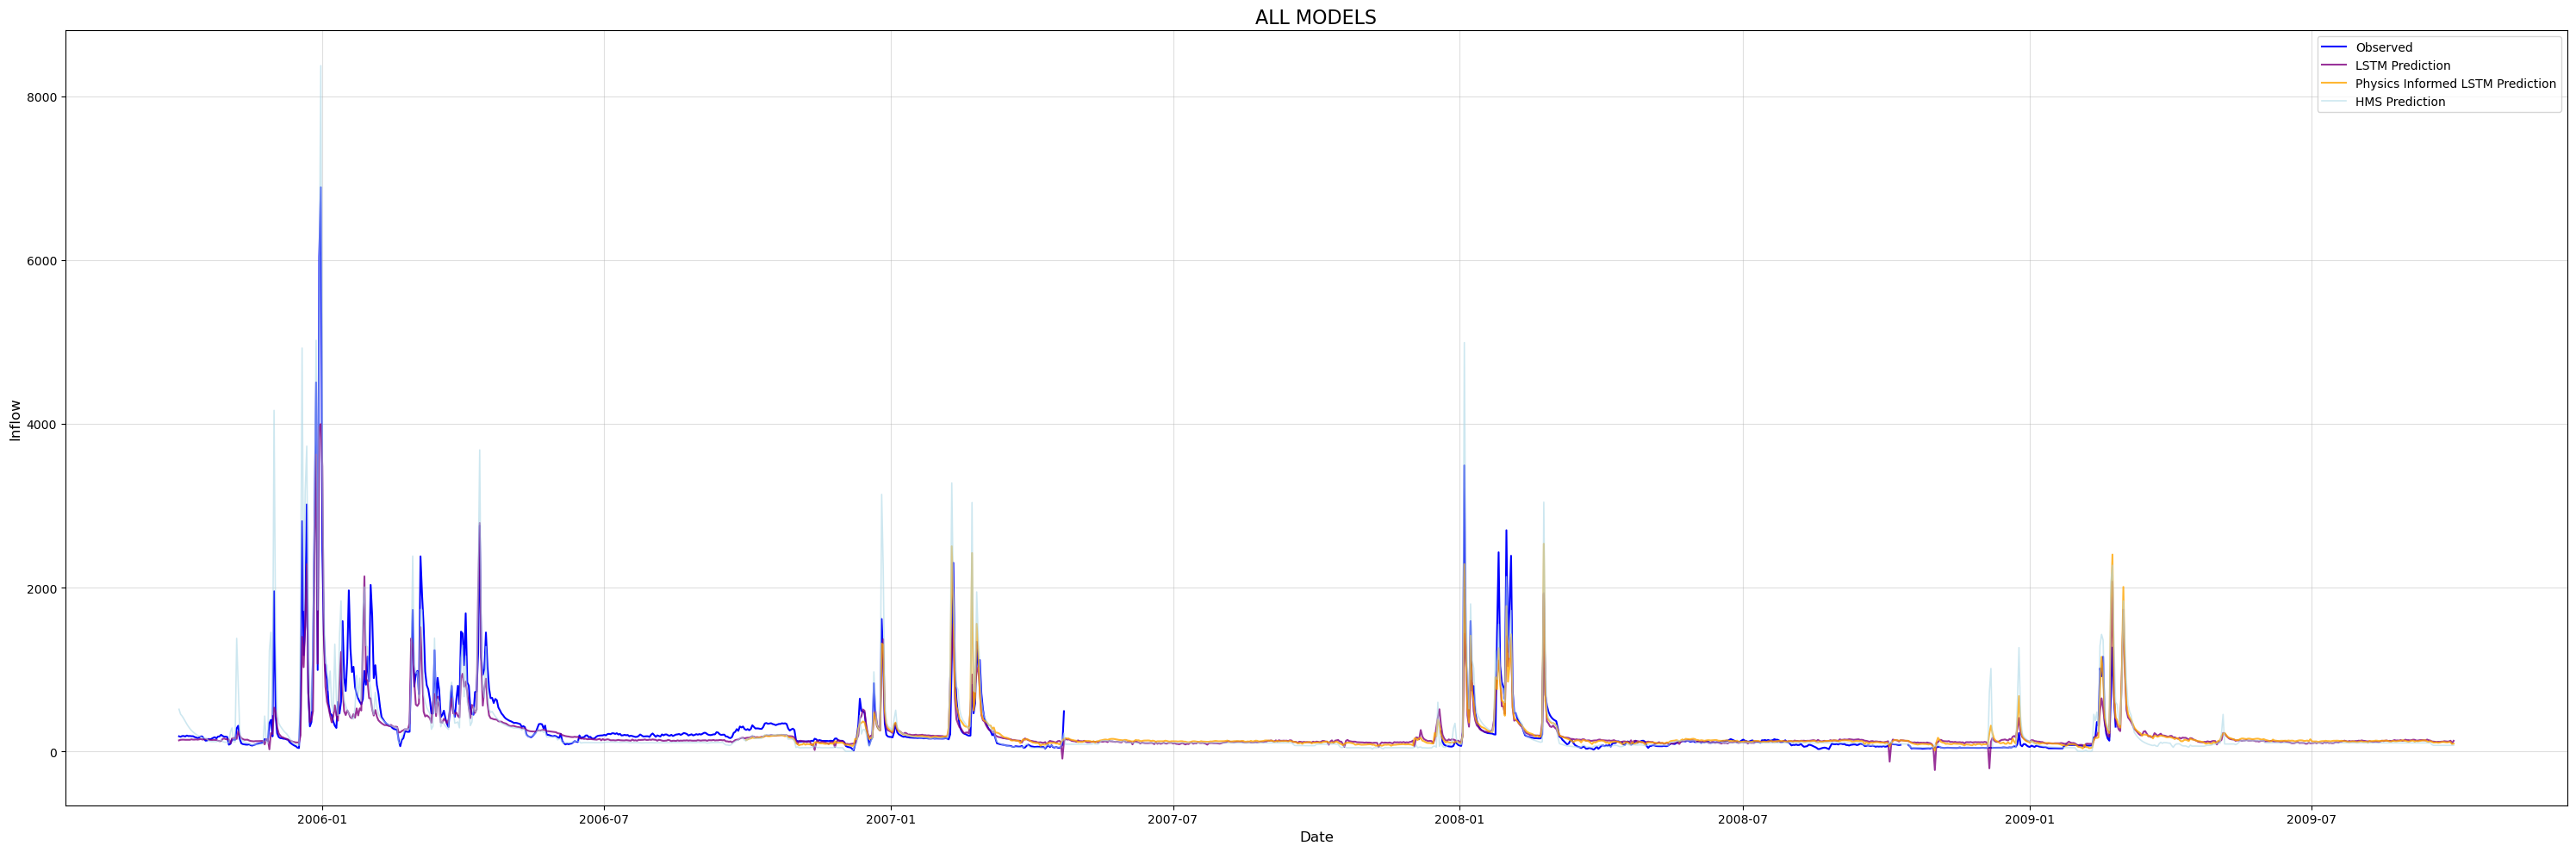

In [16]:
lstm_result_path = Path('/Users/mia/research/UCB-USACE-LSTMs/neuralhydrology/calpella_all/runs/testing_run_3011_133451/results_output.csv')
physics_informed_result_path = Path('/Users/mia/research/UCB-USACE-LSTMs/neuralhydrology/calpella_all/runs/testing_run_3011_134216/results_output.csv')
path_to_physics_data = Path("/Users/mia/research/russian_river_data_folder/calpella.csv")
combinedPlot(lstm_results=lstm_result_path, lstmPhysics_results= physics_informed_result_path, HMS_results=path_to_physics_data, title='ALL MODELS')

In [17]:
import plotly.graph_objects as go

def combinedPlotFancy(lstm_results: Path, lstmPhysics_results: Path, HMS_results: Path, title: str, 
                 test_start_date="01/10/2005", test_end_date="30/09/2009"):
    # Load and preprocess Model 1 (LSTM)
    model1_df = pd.read_csv(lstm_results)  # Columns: Date, Observed, Predicted
    model1_df = model1_df.rename(columns={
        'Date': 'date',
        'Observed': 'Observed_Model1',
        'Predicted': 'Predicted_Model1'
    })
    model1_df['date'] = pd.to_datetime(model1_df['date'])

    # Load and preprocess Model 2 (Physics-Informed LSTM)
    model2_df = pd.read_csv(lstmPhysics_results)  # Columns: Date, Observed, Predicted
    model2_df = model2_df.rename(columns={
        'Date': 'date',
        'Observed': 'Observed_Model2',
        'Predicted': 'Predicted_Model2'
    })
    model2_df['date'] = pd.to_datetime(model2_df['date'])

    # Load and preprocess HMS results
    hms_df = pd.read_csv(HMS_results)
    hms_df = hms_df[2:]
    hms_df.columns = hms_df.columns.str.strip()
    hms_df = hms_df.drop(columns=['Ordinate'])
    hms_df = hms_df.rename(columns={'Date / Time': 'date'})
    hms_df['date'] = pd.to_datetime(hms_df['date'], format='%d-%b-%y')
    hms_df = hms_df.reset_index(drop=True)
    hms_df = hms_df.iloc[:, [0, 1]]  # Keep only Date and HMS_predicted columns
    hms_df = hms_df.rename(columns={hms_df.columns[1]: "HMS_predicted"})
    hms_df["HMS_predicted"] = pd.to_numeric(hms_df["HMS_predicted"], errors="coerce")

    # Merge dataframes
    df = model1_df.merge(model2_df, how='right', on='date').merge(hms_df, how='right', on='date')

    # Filter for the test period
    test_start_date = pd.to_datetime(test_start_date, format='%d/%m/%Y')
    test_end_date = pd.to_datetime(test_end_date, format='%d/%m/%Y')
    df = df[(df['date'] >= test_start_date) & (df['date'] <= test_end_date)]

    # Create Plotly figure
    fig = go.Figure()

    # Add traces for each model
    fig.add_trace(go.Scatter(x=df["date"], y=df["Observed_Model1"], mode='lines',
                             name='Observed', line=dict(width=1.5)))
    fig.add_trace(go.Scatter(x=df["date"], y=df["Predicted_Model1"], mode='lines',
                             name='LSTM Prediction', line=dict(width=1.5)))
    fig.add_trace(go.Scatter(x=df["date"], y=df["Predicted_Model2"], mode='lines',
                             name='Physics-Informed LSTM Prediction', line=dict(width=1.5)))
    fig.add_trace(go.Scatter(x=df["date"], y=df["HMS_predicted"], mode='lines',
                             name='HMS Prediction', line=dict(width=1.2)))

    # Customize layout
    fig.update_layout(
        title=title,
        xaxis_title="Date",
        yaxis_title="Inflow (cubic feet per second)",
        template="seaborn",
        hovermode="x unified",
        xaxis=dict(
            rangeslider=dict(visible=True),  # Add range slider for zooming
            rangeselector=dict(
                buttons=[
                    dict(count=1, label="1m", step="month", stepmode="backward"),
                    dict(count=6, label="6m", step="month", stepmode="backward"),
                    dict(count=1, label="1y", step="year", stepmode="backward"),
                    dict(step="all")
                ]
            )
        )
    )

    # Zoom label formatting based on zoom level
    fig.update_xaxes(
        tickformatstops=[
            dict(dtickrange=[None, 1000], value="%Y-%m-%d"),
            dict(dtickrange=[1000, 86400000], value="%b %d, %Y"),
            dict(dtickrange=[86400000, "M1"], value="%b %Y"),
            dict(dtickrange=["M1", None], value="%Y"),
        ]
    )

    # Show plot
    fig.show()


In [18]:

combinedPlotFancy(lstm_results=lstm_result_path, lstmPhysics_results= physics_informed_result_path, HMS_results=path_to_physics_data, title='Calpella Basin Model Comparison')